# Download the most recent stock data

In [105]:
## run python script
# !python apache_data.py

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Universal Value

In [107]:
starting_date = pd.to_datetime("2025-07-30")
ending_date = pd.to_datetime("2025-08-28")
stock_ticker = "CRCL"
daily_date_range = 60
look_back_days_daily = 30
look_back_days_hourly = 5
atr_look_back_day = 5

In [108]:
def read_csv_correct_time(file_path, assume="ET"):
    """
    Pass a csv file from apache data api and turn that into a dataframe that has
    accurate timezone (NYC) with close and volume columns.
    """
    df = pd.read_csv(file_path)

    # Parse the column into datetimes
    ts = pd.to_datetime(df["date"], errors="raise")

    # Build a tz-aware DatetimeIndex in America/New_York
    if hasattr(ts, "dt") and ts.dt.tz is not None:
        # Already tz-aware → just convert to NY
        idx = ts.dt.tz_convert("America/New_York")
        idx = idx.tz_localize(None) 
    else:
        # Naive timestamps → decide what they mean
        if assume.upper() == "UTC":
            idx = pd.DatetimeIndex(ts, tz="UTC").tz_convert("America/New_York")
            idx = idx.tz_localize(None)   # strips it off
        else:  # assume they are already Eastern local time
            idx = pd.DatetimeIndex(ts, tz="America/New_York")
            idx = idx.tz_localize(None)   # strips it off

    # Use the tz-aware index
    df = df.set_index(idx)
    # Optional: drop the original column
    df = df.drop(df.columns[0], axis=1)

    # Filter to Regular Trading Hours
    df_rth = df.between_time("09:30", "16:00")
    df_rth = df_rth[["4. close", "5. volume"]]  # keep only close and volume
    df_rth.columns = ["close", "volume"]

    return df_rth

# Intraday level data

In [109]:
df_60min = read_csv_correct_time(f'data/{stock_ticker}_60min.csv')

In [110]:
def visualize_feature_trend_by_time(df, feature, look_back_days=20, plot=True):
    """
    Visualize the trend of a specific feature by time of day over a look-back period.
    Returns the *sorted* average-by-time series used in the plot.
    """
    # Build pivot: rows = date, cols = time-of-day
    date_column = df.index.date
    time_column = df.index.time
    df_pivot = df.pivot_table(index=date_column, columns=time_column, values=feature)

    # Average over last N days
    tail_block = df_pivot.tail(look_back_days)
    avg_feature_by_time = tail_block.mean(axis=0)
    avg_feature_by_time.name = f"Average {feature}"

    # Robust sort by time-of-day
    times = pd.Index(avg_feature_by_time.index)
    seconds = np.array([t.hour * 3600 + t.minute * 60 + getattr(t, "second", 0) for t in times])
    order = np.argsort(seconds)

    # Sorted x/y for plotting
    tick_labels = times.astype(str).to_numpy()[order]
    avg_sorted = avg_feature_by_time.iloc[order]

    if plot:
        plt.figure(figsize=(12, 6))

        # Use actual dates as legend labels
        day_labels = [str(d) for d in tail_block.index]

        for i, (d, row) in enumerate(tail_block.iterrows()):
            y = row.iloc[order].values
            # label every day (could be noisy; feel free to thin this)
            plt.plot(tick_labels, y, alpha=0.18, linewidth=1, label=day_labels[i])

        # Plot the average line on top
        plt.plot(tick_labels, avg_sorted.values, linewidth=2,
                 label=f"Average {feature} by time (last {look_back_days} days)")

        # Nice title/date range from the same slice you plotted
        start_date = tail_block.index.min()
        end_date = tail_block.index.max()
        plt.title(
            f"{feature.capitalize()} by Time of Day (last {look_back_days} days)\n"
            f"{start_date} → {end_date}"
        )
        plt.xlabel("Time of Day")
        plt.ylabel(feature)
        plt.xticks(tick_labels, rotation=90)
        plt.grid(True)
        plt.legend(ncol=2)  # adjust as you like
        plt.tight_layout()

        # Ensure folder exists and save
        Path("stock_image").mkdir(parents=True, exist_ok=True)
        out_path = (
            f"stock_image/Average_{feature}_by_Time_of_Day_over_{look_back_days}_days_"
            f"from_{start_date}_to_{end_date}.png"
        )
        plt.savefig(out_path, bbox_inches="tight", dpi=300)
        # plt.show()  # enable if you want to display interactively

    return avg_sorted

## Hourly Data

10:00:00    2002832.4
11:00:00     957189.0
12:00:00     668482.8
13:00:00     607851.4
14:00:00     513277.4
15:00:00    1342649.8
16:00:00     986527.8
Name: Average volume, dtype: float64

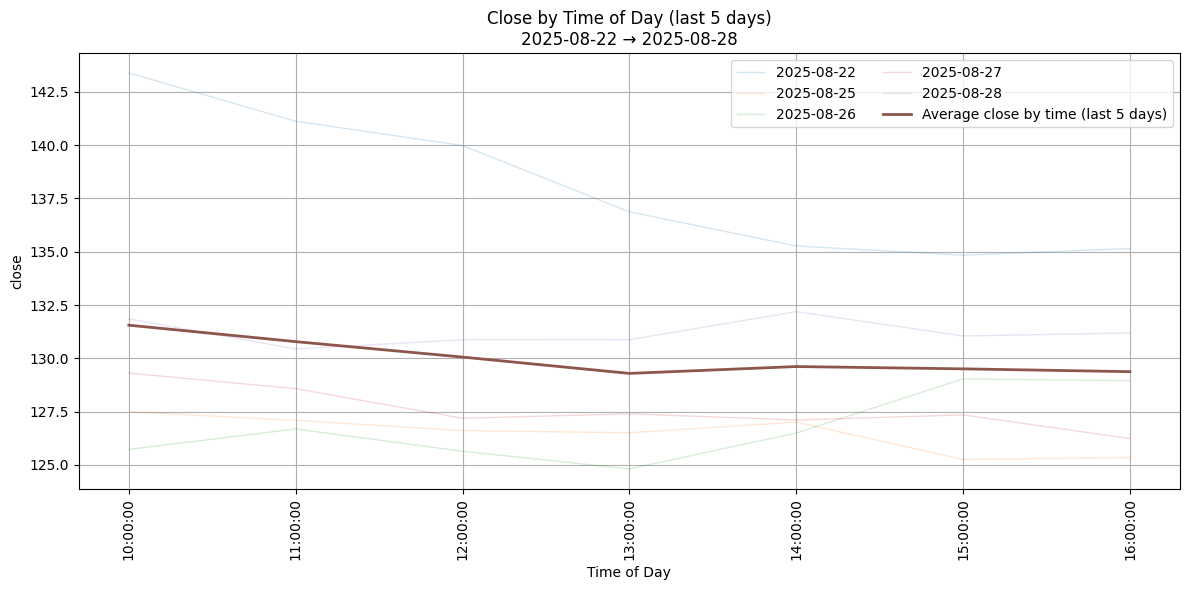

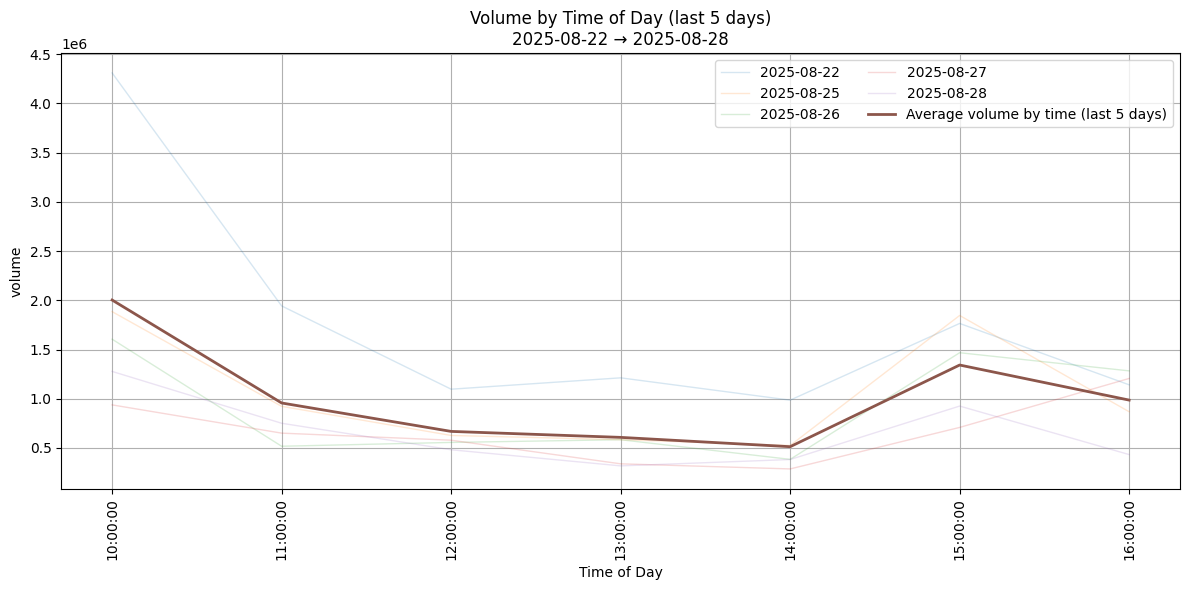

In [111]:
visualize_feature_trend_by_time(df_60min, feature="close", look_back_days=look_back_days_hourly)
visualize_feature_trend_by_time(df_60min, feature="volume", look_back_days=look_back_days_hourly)

In [112]:
def expected_cum_rvol(df_time_volume, look_back_days=look_back_days_hourly):
    cum_vol_df = df_time_volume.copy().sort_index()
    cum_vol_df["Date"] = cum_vol_df.index.date
    cum_vol_df["Time"] = cum_vol_df.index.time
    cum_vol_df["Cumulative_Volume"] = cum_vol_df.groupby("Date")["volume"].cumsum()
    pivot_cum = cum_vol_df.pivot_table(index="Date", columns="Time", values="Cumulative_Volume")
    # Not include the volume from the current day
    exp_curve = pivot_cum.rolling(window=look_back_days).mean().shift(1)
    exp_curve_long = exp_curve.stack().reset_index(name="Expected_Cumulative_Volume")
    exp_curve_long["Datetime"] = pd.to_datetime(exp_curve_long["Date"].astype(str) + " " + exp_curve_long["Time"].astype(str))
    exp_curve_long = exp_curve_long.drop(columns=["Date", "Time"])
    exp_curve_long = exp_curve_long.set_index("Datetime").sort_index()
    return exp_curve_long

def intraday_rvol(min_df: pd.DataFrame, exp_cum_df: pd.DataFrame, look_back_days=look_back_days_hourly) -> pd.DataFrame:
    """
    Computes Intraday_RVOL_cum = CumVolume / Exp_CumVolume.
    """
    df = min_df[["close", "volume"]].copy().sort_index()
    df["CumVolume"] = df.groupby(df.index.date)["volume"].cumsum()
    joined = df.join(exp_cum_df, how="left")
    joined["Intraday_RVOL_cum"] = joined["CumVolume"] / joined["Expected_Cumulative_Volume"]
    return joined

def visualize_intraday_rvol(df_intraday_rvol):
    df = df_intraday_rvol.copy()
    df["Date"] = df.index.date
    df["Hour"] = df.index.hour
    
    # Sort unique dates so earliest → lightest, latest → darkest
    unique_dates = sorted(df["Date"].unique())
    norm = mcolors.Normalize(vmin=0, vmax=len(unique_dates)-1)
    cmap = cm.get_cmap("viridis_r")  # you can try "plasma", "cividis", etc.
    
    plt.figure(figsize=(20, 10))
    for i, (date, group) in enumerate(df.groupby("Date")):
        color = cmap(norm(i))  # darker for later dates
        plt.plot(group["Hour"], group["Intraday_RVOL_cum"], 
                 label=str(date), color=color)
    
    plt.xlabel("Hour of Day")
    plt.ylabel("Intraday RVOL Cumulative")
    plt.title("Intraday Relative Volume (Cumulative) by Hour")
    plt.legend()
    plt.grid(True)
    plt.show()

/var/folders/sr/t9b4x2mn7s35cskh4j9lc0qh0000gn/T/ipykernel_1825/95634764.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis_r")  # you can try "plasma", "cividis", etc.


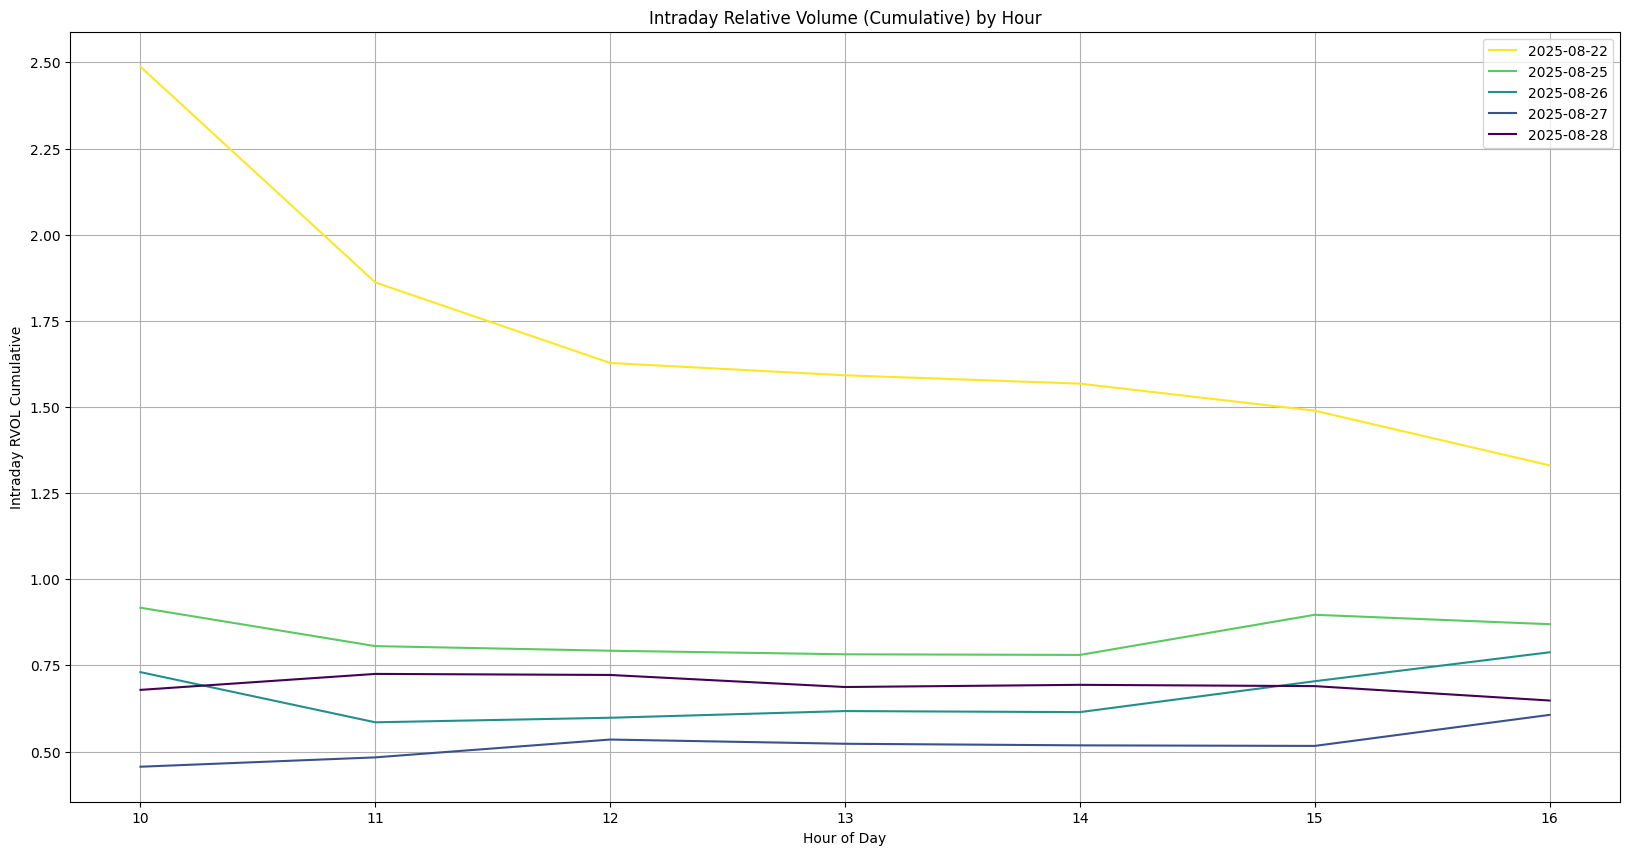

,close,volume,CumVolume,Expected_Cumulative_Volume,Intraday_RVOL_cum
date,,,,,
2025-07-30 10:00:00,187.2270,1849091.0,1849091.0,NaN,NaN
2025-07-30 11:00:00,188.1400,928778.0,2777869.0,NaN,NaN
2025-07-30 12:00:00,187.4200,440554.0,3218423.0,NaN,NaN
2025-07-30 13:00:00,187.9850,273987.0,3492410.0,NaN,NaN
2025-07-30 14:00:00,185.6800,1118442.0,4610852.0,NaN,NaN
...,...,...,...,...,...
2025-08-28 12:00:00,130.8726,482050.0,2510890.0,3476919.0,0.722159
2025-08-28 13:00:00,130.8750,318471.0,2829361.0,4117416.6,0.687169
2025-08-28 14:00:00,132.1900,382977.0,3212338.0,4632005.2,0.693509


In [113]:
exp_60min_volume = expected_cum_rvol(df_60min)
intra_day_df = intraday_rvol(df_60min, exp_60min_volume)
visualize_intraday_rvol(intra_day_df.tail(7*look_back_days_hourly))
intra_day_df

# Daily Data

## Daily Volume & Close

In [114]:
def daily_data_handler(daily_raw_df, daterange = daily_date_range):
    """
    Processes raw daily data by renaming columns, localizing timezone, and setting the date as the index.
    """
    df_daily = daily_raw_df.copy()
    df_daily.columns = ["date", "open", "high", "low", "close", "volume"]
    df_daily["date"] = pd.to_datetime(df_daily["date"]).dt.tz_localize("America/New_York")
    df_daily = df_daily.set_index("date")

    return df_daily.tail(daterange)

In [115]:
def daily_data_feature(df_daily, feature, lookback=look_back_days_daily, plot=True):
    """
    Computes and visualizes a specified feature from daily data with a given lookback period.

    Parameters:
    - df_daily (pd.DataFrame): DataFrame containing daily data with a DateTime index.
    - feature (str): The feature/column name to analyze.
    - lookback (int): Number of days to look back for computing the feature.
    - plot (bool): Whether to plot the feature.

    Returns:
    - pd.DataFrame: DataFrame containing the specified feature.
    """

    # Select relevant columns
    df_daily = df_daily.loc[:, [feature]].copy()

    # Extract feature as DataFrame
    df_feature = df_daily[[feature]]

    
    if plot:
        plt.figure(figsize=(20, 10))
        plt.plot(df_feature.index, df_feature[feature], marker="o")
        plt.title(f"Daily {feature.capitalize()} with {lookback}-Day Lookback \n from {df_feature.index.min().date()} to {df_feature.index.max().date()}")
        plt.xlabel("Date")
        plt.ylabel(feature.capitalize())
        plt.grid(True)
        plt.xticks(df_feature.index, rotation=90)  # rotate labels, let matplotlib auto-select ticks
        plt.tight_layout()
        plt.legend()
        plt.show()

    return df_feature

In [116]:
def rvol_daily_plot(volume: pd.Series, lookback: int = look_back_days_daily, plot: bool = True) -> pd.DataFrame:
    """Compute RVOL from a Series of volume indexed by date."""
    ## use ema
    volume["avgvol"] = volume["volume"].ewm(span=lookback, adjust=False).mean()
    volume["rvol"] = volume["volume"] / volume["avgvol"]
    volume = volume.tail(lookback)

    if plot:   
        plt.figure(figsize=(20, 10))
        plt.plot(volume.index, volume["rvol"], label="RVOL")
        for x, y in zip(volume.index, volume["rvol"]):
            plt.text(
                x, y, 
                f"{y:.2f}",  # format to 2 decimals
                ha="center", va="bottom", fontsize=8
            )
        plt.title("Relative Volume (RVOL) Over Time with Lookback of " + str(lookback) + " Days \n from " + str(volume.index.min().date()) + " to " + str(volume.index.max().date()))
        plt.xticks(volume.index, rotation=90)
        plt.xlabel("Date")
        plt.ylabel("RVOL")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return volume

/var/folders/sr/t9b4x2mn7s35cskh4j9lc0qh0000gn/T/ipykernel_1825/3395886922.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


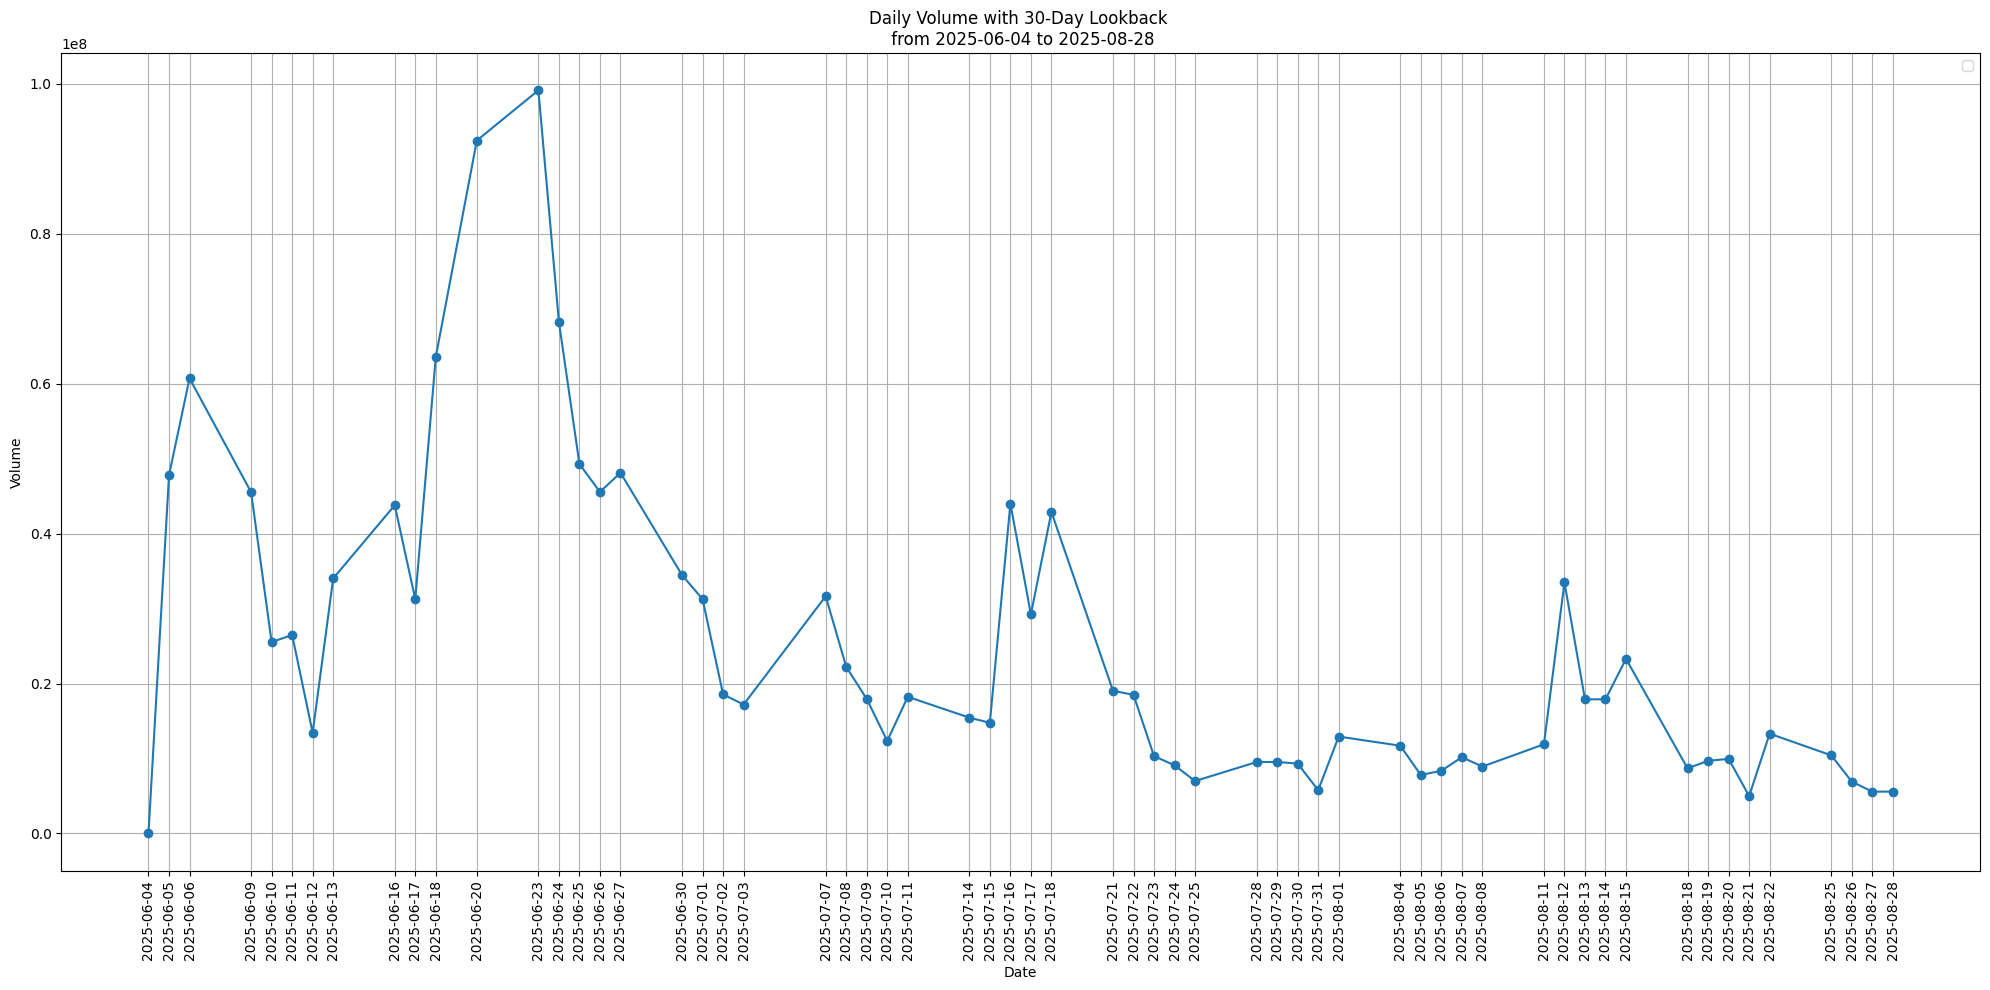

/var/folders/sr/t9b4x2mn7s35cskh4j9lc0qh0000gn/T/ipykernel_1825/3395886922.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


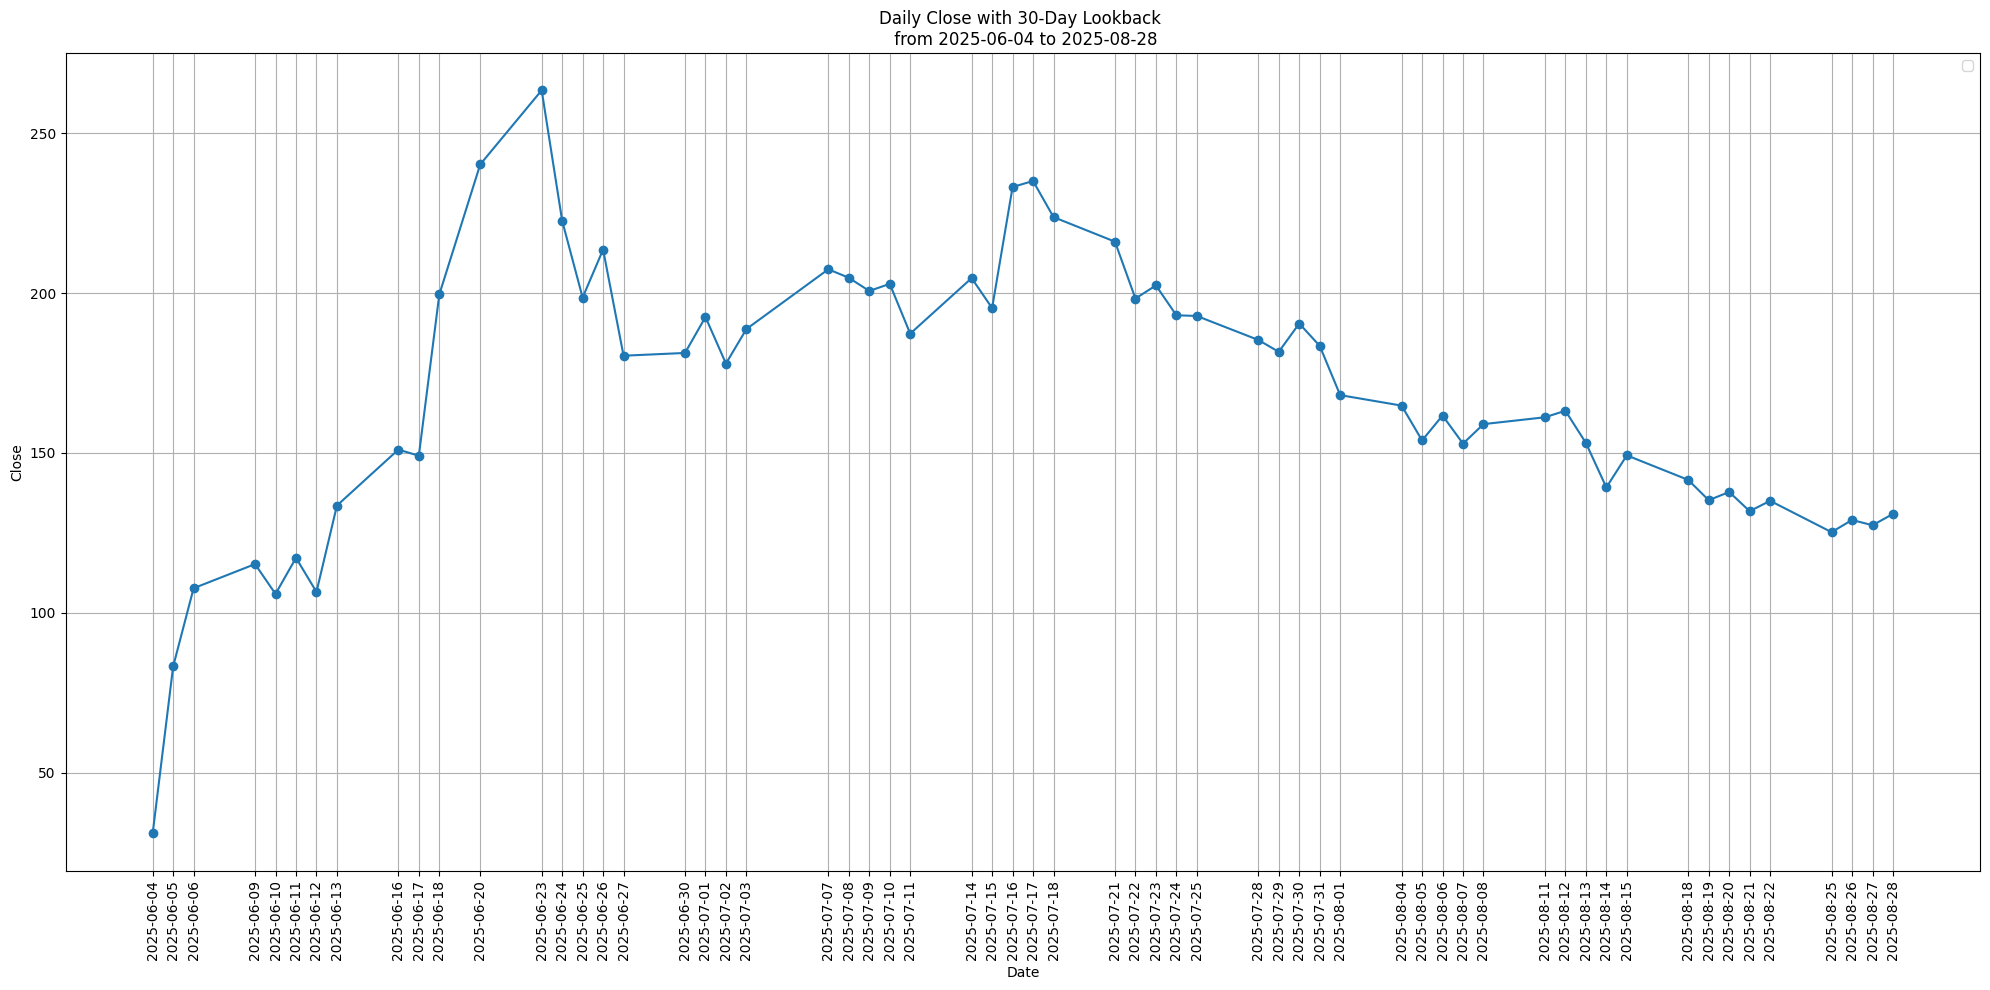

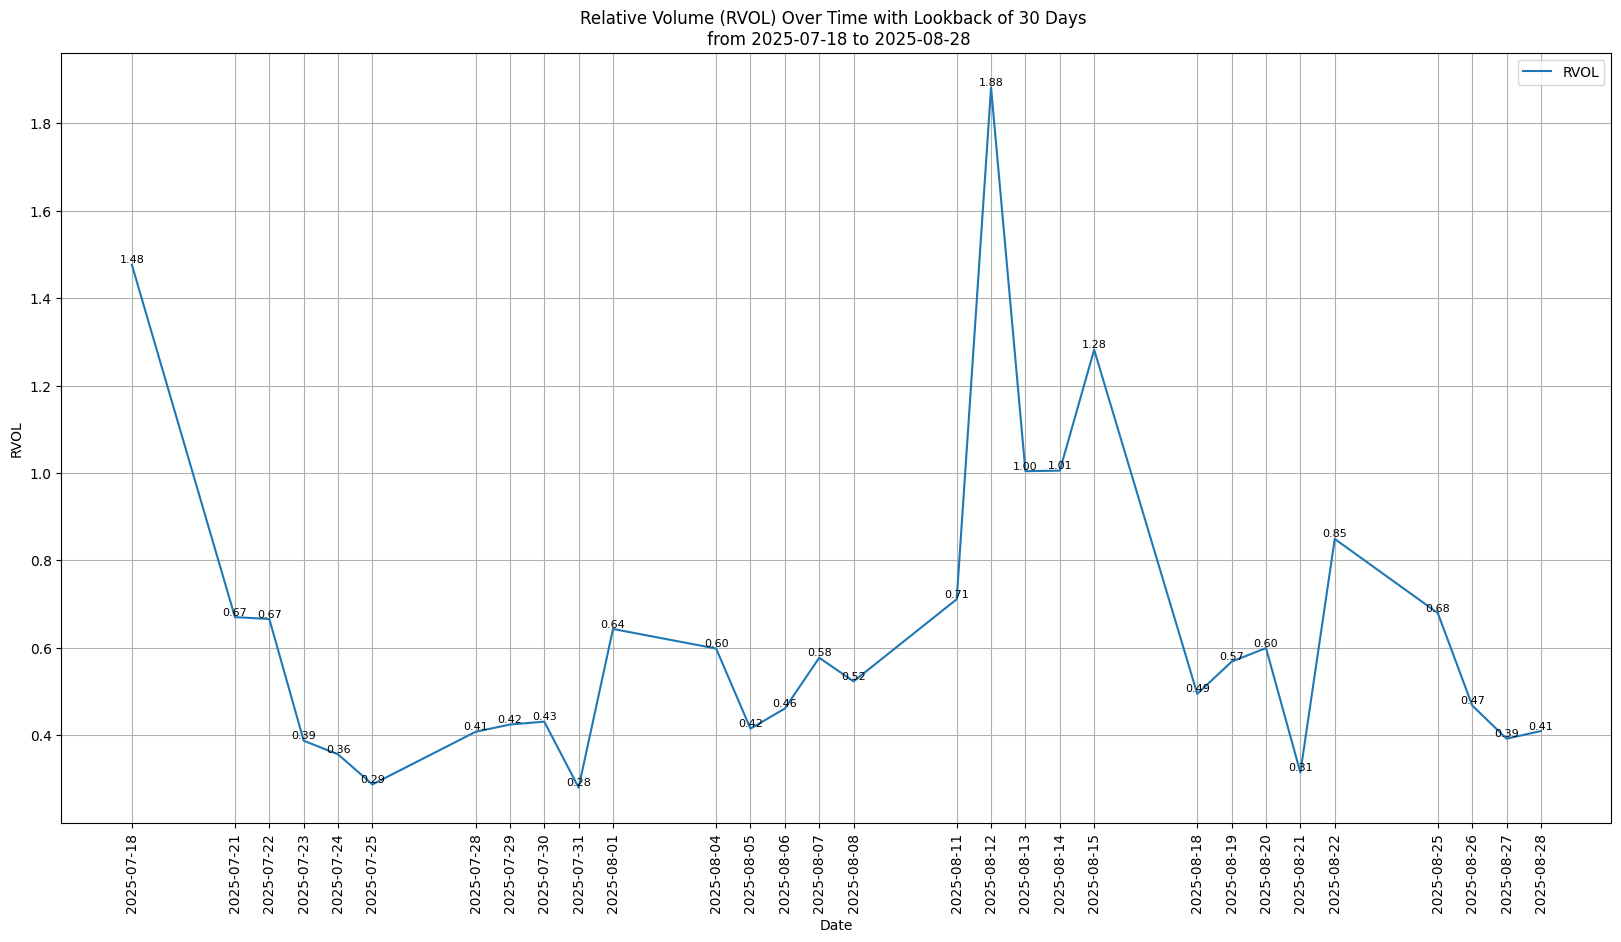

In [118]:
daily_raw_df = pd.read_csv(f"data/{stock_ticker}_daily.csv")
daily_df = daily_data_handler(daily_raw_df)
daily_volume_df = daily_data_feature(daily_df, "volume")
daily_close_df = daily_data_feature(daily_df, "close")
daily_rvol_df = rvol_daily_plot(daily_volume_df)

## Daily ATR price

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def atr_price(
    df: pd.DataFrame,
    lookback: int = atr_look_back_day,
    method: str = "wilder",  # "sma" or "wilder"
    plot: bool = True,
    title: str | None = None
) -> pd.Series:
    """
    Compute ATR (in price units) from OHLC data.

    Accepts either Alpha Vantage columns ("1. open", "2. high", ...)
    or standard columns ("Open","High","Low","Close"). Index should be
    datetime or a 'date' column must be present.
    """

    def pick(colnames):
        for name in colnames:
            if name in df.columns:
                return df[name]
        raise KeyError(f"None of {colnames} found in df.columns={list(df.columns)}")

    # Index handling
    if "date" in df.columns:
        idx = pd.to_datetime(df["date"])
    else:
        idx = pd.to_datetime(df.index)

    # Robust column selection
    high   = pick(["High", "high", "2. high"])
    low    = pick(["Low", "low", "3. low"])
    close  = pick(["Close", "close", "4. close"])

    # Ensure numeric
    high  = pd.to_numeric(high, errors="coerce")
    low   = pd.to_numeric(low, errors="coerce")
    close = pd.to_numeric(close, errors="coerce")

    # True Range
    prev_close = close.shift(1)
    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)
    tr.index = idx

    # ATR
    method = method.lower()
    if method == "wilder":
        atr = tr.ewm(alpha=1 / lookback, adjust=False).mean()
    elif method == "sma":
        atr = tr.rolling(window=lookback, min_periods=lookback).mean()
    else:
        raise ValueError("method must be 'sma' or 'wilder'")

    atr.name = f"ATR_{method}_{lookback}"

    if plot:
        plt.figure(figsize=(20, 10))
        plt.plot(atr.index, atr, label=f"ATR ({method}, n={lookback})")
        ttl = title or f"Average True Range — {lookback}-period ({method.title()})"
        start = pd.to_datetime(atr.index.min()).date() if len(atr) else ""
        end   = pd.to_datetime(atr.index.max()).date() if len(atr) else ""
        plt.title(f"{ttl}\n{start} to {end}")
        plt.xlabel("Date")
        plt.ylabel("ATR (price units)")
        plt.grid(True)
        plt.legend()
        plt.xticks(atr.index, rotation=90)
        plt.tight_layout()
        plt.show()

    return atr

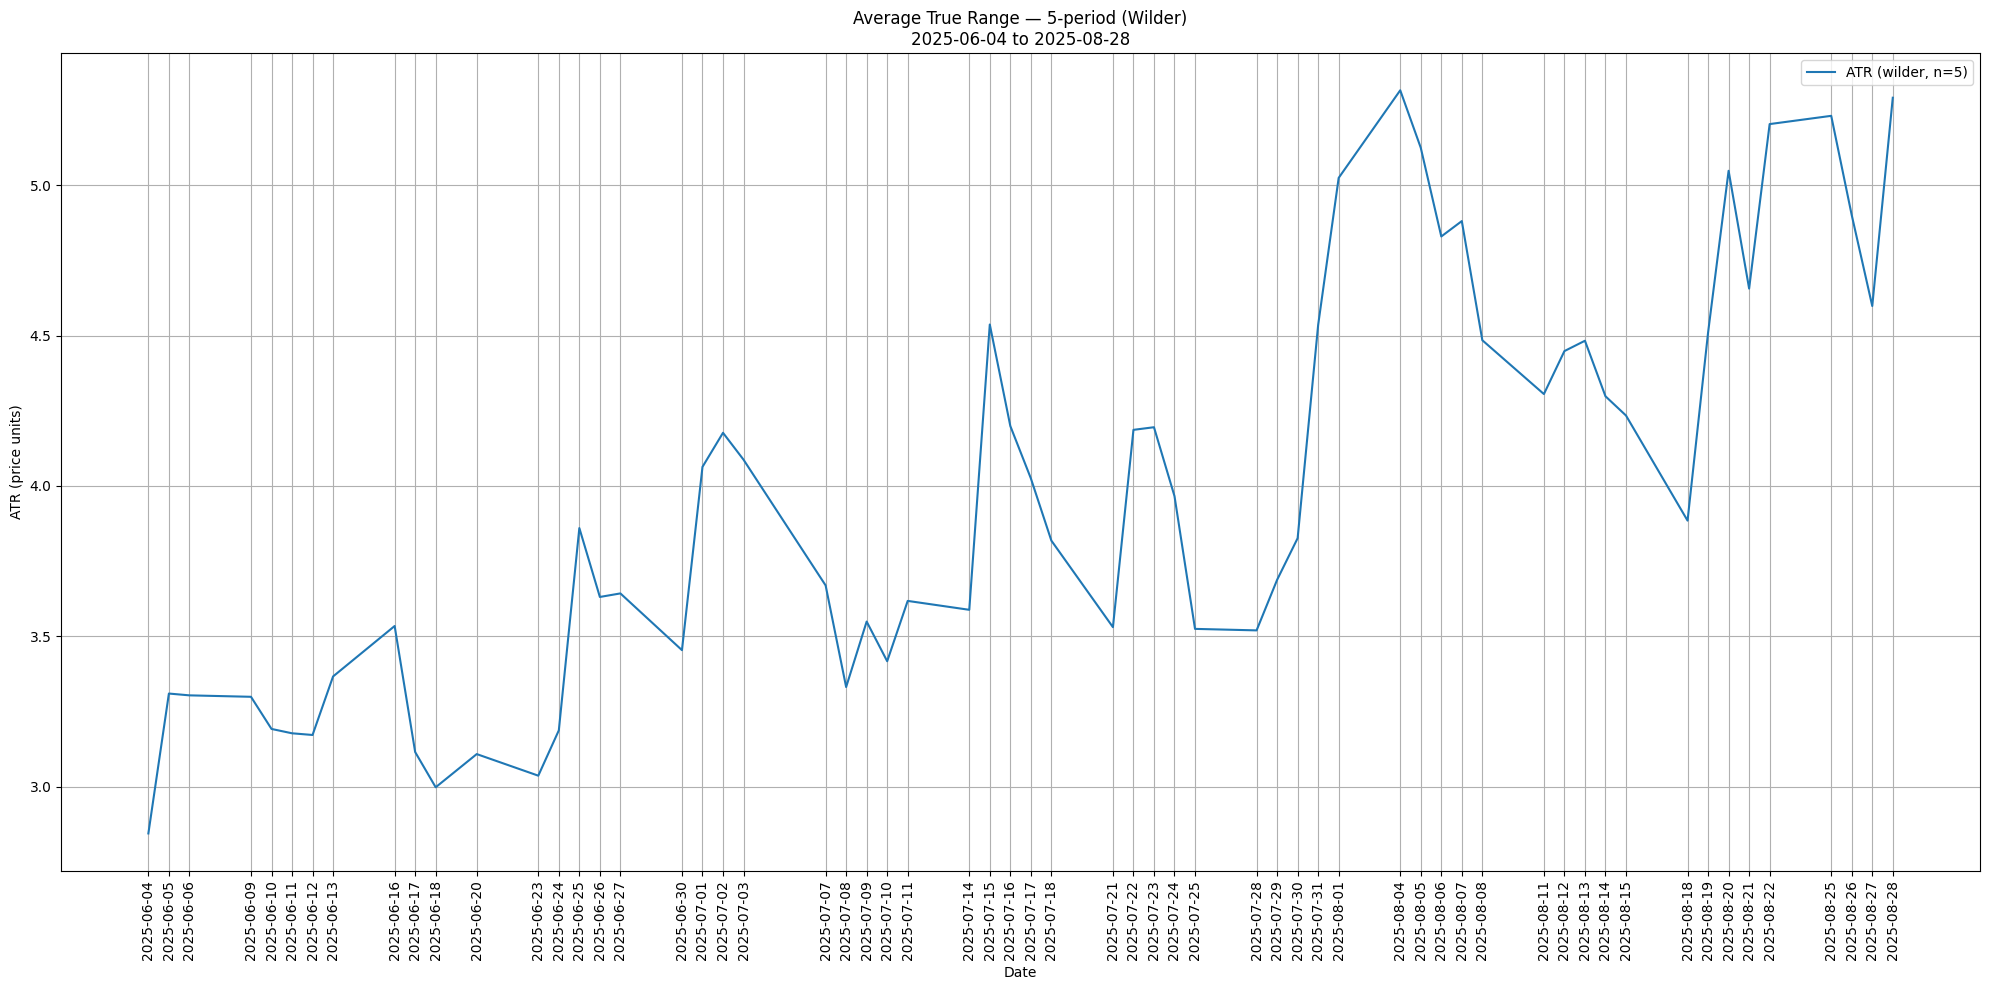

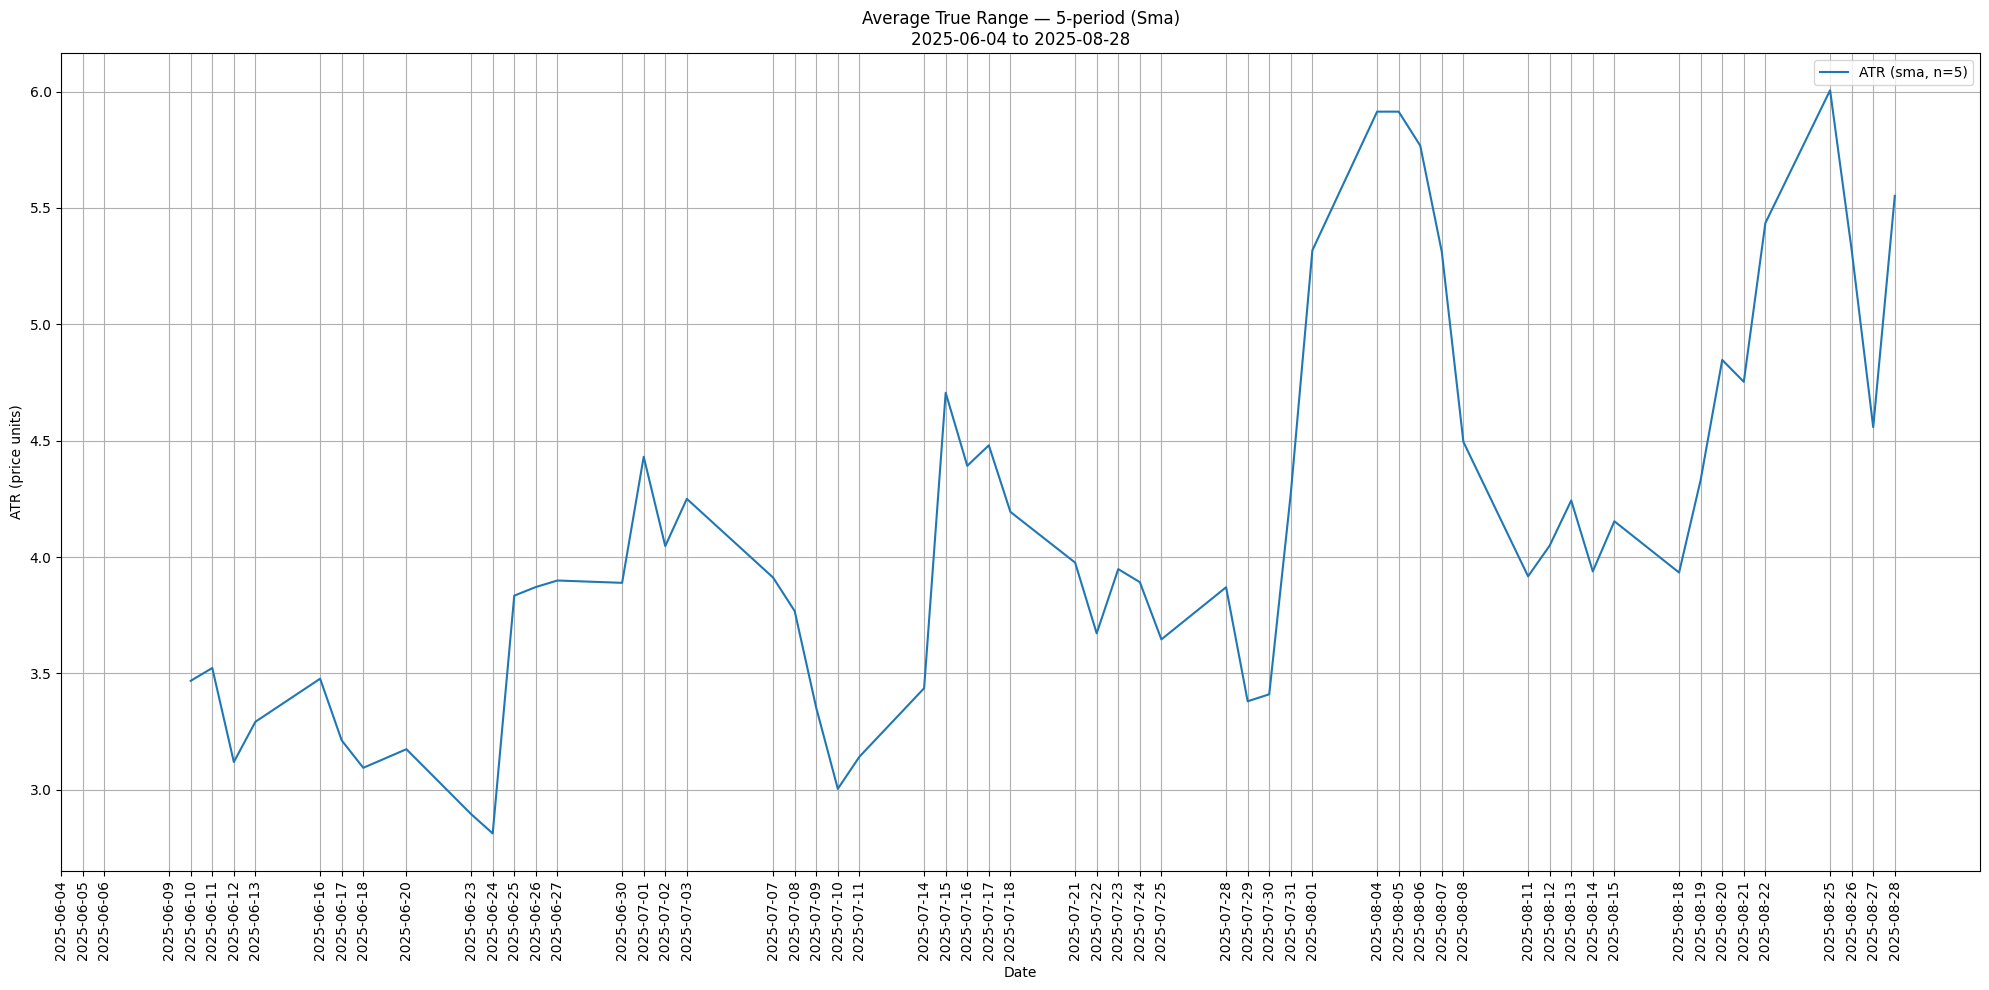

date
2025-06-04 00:00:00-04:00        NaN
2025-06-05 00:00:00-04:00        NaN
2025-06-06 00:00:00-04:00        NaN
2025-06-09 00:00:00-04:00        NaN
2025-06-10 00:00:00-04:00    3.46800
2025-06-11 00:00:00-04:00    3.52300
2025-06-12 00:00:00-04:00    3.11900
2025-06-13 00:00:00-04:00    3.29200
2025-06-16 00:00:00-04:00    3.47700
2025-06-17 00:00:00-04:00    3.21200
2025-06-18 00:00:00-04:00    3.09400
2025-06-20 00:00:00-04:00    3.17400
2025-06-23 00:00:00-04:00    2.89500
2025-06-24 00:00:00-04:00    2.81200
2025-06-25 00:00:00-04:00    3.83400
2025-06-26 00:00:00-04:00    3.87100
2025-06-27 00:00:00-04:00    3.89900
2025-06-30 00:00:00-04:00    3.88900
2025-07-01 00:00:00-04:00    4.43100
2025-07-02 00:00:00-04:00    4.04700
2025-07-03 00:00:00-04:00    4.25000
2025-07-07 00:00:00-04:00    3.91160
2025-07-08 00:00:00-04:00    3.76760
2025-07-09 00:00:00-04:00    3.35160
2025-07-10 00:00:00-04:00    3.00360
2025-07-11 00:00:00-04:00    3.14160
2025-07-14 00:00:00-04:00    3.43

In [ ]:
atr_price(daily_df)
atr_price(daily_df, method="sma")